# Demonstrating Brian2 with STDP
First, let's implement the model as described in Figure 1 of [Goodman and Brette, 2009](https://doi.org/10.3389/neuro.01.026.2009) (i.e. showing spike-timing dependent plasticity); some syntax is updated for Brian2 as shown in the package documentation. This implementation uses Poisson input neurons with a rate of 15 Hz.

In [1]:
import matplotlib.pyplot as plt
from brian2 import *

%matplotlib inline

np.random.seed(294839)

In [2]:
# Define variables for the model
N = 1000
taum = 10*ms
taupre = taupost = 20*ms
Ee = 0*mV
VT = -54*mV
VR = -60*mV
El = -74*mV
taue = 5*ms
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

In [3]:
# Define output neuron LEAKY INTEGRATE AND FIRE equations and STDP synapse equations
eqs_neurons = '''
dV/dt = (ge * (Ee - VR) + El - V) / taum : volt
dge/dt = -ge / taue                      : 1
'''
eqs_synapses = '''
w : 1
dApre/dt  = -Apre / taupre   : 1 (event-driven)
dApost/dt = -Apost / taupost : 1 (event-driven)
'''

In [4]:
# Implement and simulate the model as described in the paper
start_scope()

poisson_in = PoissonGroup(N, rates=15*Hz)
neuron_out = NeuronGroup(1, eqs_neurons, threshold='V>VT', reset='V=VR', method='exact')

S = Synapses(poisson_in, neuron_out, eqs_synapses,
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'

#wts_mon = StateMonitor(S, 'w', record=[0, 1])
psn_in_spks = SpikeMonitor(poisson_in)
out_spks = SpikeMonitor(neuron_out)
psn_in_rate = PopulationRateMonitor(poisson_in)
out_rate = PopulationRateMonitor(neuron_out)

run(100*second, report='text')

Starting simulation at t=0. s for a duration of 100. s
13.2686 (13%) simulated in 10s, estimated 1m 5s remaining.
26.4292 (26%) simulated in 20s, estimated 56s remaining.
39.5501 (39%) simulated in 30s, estimated 46s remaining.
52.699400000000004 (52%) simulated in 40s, estimated 36s remaining.
65.80030000000001 (65%) simulated in 50s, estimated 26s remaining.
78.93260000000001 (78%) simulated in 1m 0s, estimated 16s remaining.
92.1907 (92%) simulated in 1m 10s, estimated 6s remaining.
100.0 (100%) simulated in 1m 15s


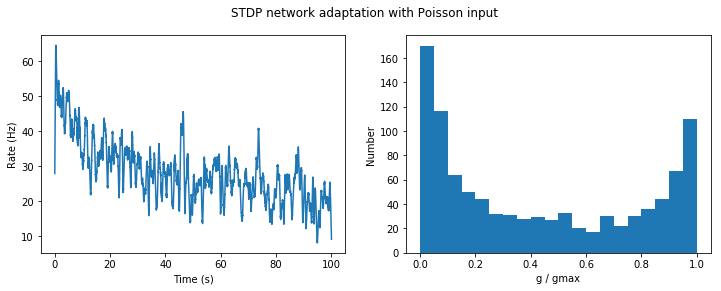

In [5]:
# Recreate the plots from Figure 1
figure(figsize=(12,4))
subplot(121)
ylabel('Rate (Hz)')
xlabel('Time (s)')
plot(out_rate.t/second, out_rate.smooth_rate(width=0.2*second)/Hz)
subplot(122)
hist(S.w / gmax, 20)
xlabel('g / gmax')
ylabel('Number')
suptitle('STDP network adaptation with Poisson input')
show()

Next, I replace the Poisson input neurons with simple LIF neurons with some randomized current input; the differential equation for these input cells contains a leakage potential `El`, an input current `Iin`, and an abstracted input membrane resistance `gin`.

In [6]:
# Define the LIF equations
eqs_lif_inp = '''
dV/dt = (gin*Iin + El - V)/taum : volt
Iin : amp
'''

# Value of gin is based on a typical 10 MOhm/cm^2 membrane resistance
gin = 10000 * ohm

In [7]:
# Implement and run new simulation with LIF input neurons
start_scope()

in_lif = NeuronGroup(N, eqs_lif_inp, threshold='V>VT', reset='V=VR', method='exact')
in_lif.Iin = '(2000 + 10*rand()) * nA'
# in_lif.Iin = '(2000 + 0.01*i) * nA'
in_lif.V = VR

out_lif = NeuronGroup(1, eqs_neurons, threshold='V>VT', reset='V=VR', method='exact')
S_lif = Synapses(in_lif, out_lif, eqs_synapses,
                 on_pre='''ge += w
                        Apre += dApre
                        w = clip(w + Apost, 0, gmax)''',
                 on_post='''Apost += dApost
                         w = clip(w + Apre, 0, gmax)'''
                )
S_lif.connect()
S_lif.w = 'rand() * gmax'


#wts_lif = StateMonitor(S_lif, 'w', record=[0, 1])
in_lif_spks = SpikeMonitor(in_lif)
out_lif_spks = SpikeMonitor(out_lif)
in_lif_rate  = PopulationRateMonitor(in_lif)
out_lif_rate = PopulationRateMonitor(out_lif)

#in_lif_V = StateMonitor(input_lif, 'V', record=True)
#in_lif_I = StateMonitor(in_lif, 'Iin', record=0)


run(100*second, report='text')

Starting simulation at t=0. s for a duration of 100. s
10.2722 (10%) simulated in 10s, estimated 1m 27s remaining.
19.5072 (19%) simulated in 20s, estimated 1m 23s remaining.
30.7265 (30%) simulated in 30s, estimated 1m 8s remaining.
43.0123 (43%) simulated in 40s, estimated 53s remaining.
56.4566 (56%) simulated in 50s, estimated 39s remaining.
69.9221 (69%) simulated in 1m 0s, estimated 26s remaining.
82.5757 (82%) simulated in 1m 10s, estimated 15s remaining.
94.57000000000001 (94%) simulated in 1m 20s, estimated 5s remaining.
100.0 (100%) simulated in 1m 24s


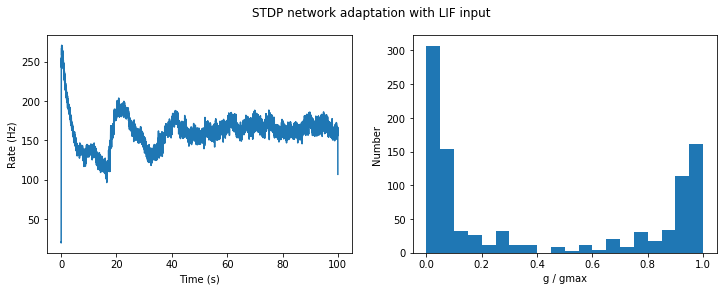

In [8]:
# Recreate Figure 1 again with LIF neurons
figure(figsize=(12,4))
subplot(121)
ylabel('Rate (Hz)')
xlabel('Time (s)')
plot(out_lif_rate.t/second, out_lif_rate.smooth_rate(width=0.02*second)/Hz)
subplot(122)
hist(S_lif.w / gmax, 20)
xlabel('g / gmax')
ylabel('Number')
suptitle('STDP network adaptation with LIF input')
show()

Next, I add a refractory period to the LIF model implemented above to see if this extra constraint changes the outcome of the STDP network.

In [9]:
# Add refractory part to LIF equation
eqs_ref_inp = '''
dV/dt = (gin*Iin + El - V)/taum : volt (unless refractory)
Iin : amp
'''

In [10]:
# Implement and run new refractory simulation
start_scope()

in_ref = NeuronGroup(N, eqs_ref_inp, threshold='V>VT', reset='V=VR', method='exact', refractory=10*ms)
in_ref.Iin = '(2000 + 5*rand()) * nA'
# in_lif.Iin = '(2000 + 0.01*i) * nA'
in_ref.V = VR

out_ref = NeuronGroup(1, eqs_neurons, threshold='V>VT', reset='V=VR', method='exact')
S_ref = Synapses(in_ref, out_ref, eqs_synapses,
                 on_pre='''ge += w
                        Apre += dApre
                        w = clip(w + Apost, 0, gmax)''',
                 on_post='''Apost += dApost
                         w = clip(w + Apre, 0, gmax)'''
                )
S_ref.connect()
S_ref.w = 'rand() * gmax'


wts_ref = StateMonitor(S_ref, 'w', record=[0, 1])
in_ref_spks = SpikeMonitor(in_ref)
out_ref_spks = SpikeMonitor(out_ref)
in_ref_rate  = PopulationRateMonitor(in_ref)
out_ref_rate = PopulationRateMonitor(out_ref)

#in_ref_V = StateMonitor(input_ref, 'V', record=True)
#in_ref_I = StateMonitor(input_ref, 'Iin', record=True)


run(100*second, report='text')

Starting simulation at t=0. s for a duration of 100. s
10.197000000000001 (10%) simulated in 10s, estimated 1m 28s remaining.
19.325400000000002 (19%) simulated in 20s, estimated 1m 23s remaining.
30.2421 (30%) simulated in 30s, estimated 1m 9s remaining.
41.7993 (41%) simulated in 40s, estimated 56s remaining.
53.6269 (53%) simulated in 50s, estimated 43s remaining.
65.6558 (65%) simulated in 1m 0s, estimated 31s remaining.
77.86800000000001 (77%) simulated in 1m 10s, estimated 20s remaining.
90.0141 (90%) simulated in 1m 20s, estimated 9s remaining.
100.0 (100%) simulated in 1m 28s


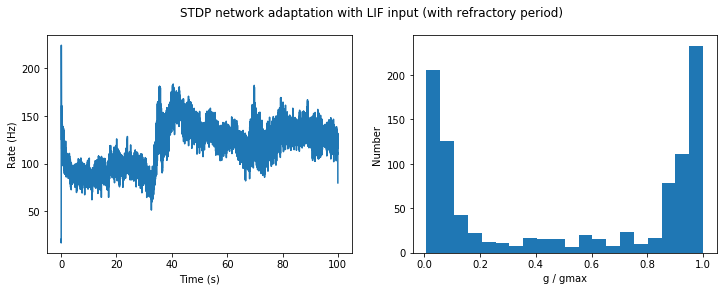

In [11]:
# Recreate Figure 1 yet again
figure(figsize=(12,4))
subplot(121)
ylabel('Rate (Hz)')
xlabel('Time (s)')
plot(out_ref_rate.t/second, out_ref_rate.smooth_rate(width=0.02*second)/Hz)
subplot(122)
hist(S_ref.w / gmax, 20)
xlabel('g / gmax')
ylabel('Number')
suptitle('STDP network adaptation with LIF input (with refractory period)')
show()

### Part A - Discussion

Whether receiving Poisson spike train input or integrate-and-fire spike trains generated with randomized current input, the synaptic plasticity of the network adjusts the weights to a bimodal distribution. This bimodal distribution effectively pares down the synaptic connections such that most synapses are either negligble or strong, with a small subset of the synapses retaining a middling weight. For the LIF input, the bimodal distribution is more pronounced than for the Poisson input, with far fewer synapses having weights that fall out of the two lobes of the distribution. This should not be surprising; the input to each neuron is randomly chosen, but stays constant throughout the simulation, effectively setting a fixed firing rate for the cell. The Poisson input, however, is variable across time and thus the network settles to a more even, smooth bimodal distribution.

In the case of the Poisson input, which itself has an average rate of $15 Hz$, the network also adapts to a similar population rate over the runtime of the simulation. The network with LIF input also adapts to a particular firing rate, but that rate is based on the randomized current inputs to the input neurons, as discussed above.